In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

import efficientnet
import efficientnet.tfkeras as efn

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2022-05-11 14:01:03.670149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df =pd.read_csv(current_path+'/label-{}.csv'.format(int(case_name[-2:])))
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

all_img_path, all_label = get_train_data('./data/train')
test_img_path = get_test_data('./data/test')

In [6]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [7]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

2022-05-11 14:07:14.856017: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-11 14:07:14.857133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-11 14:07:14.913915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 14:07:14.914550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-11 14:07:14.914591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-11 14:07:15.012377: I tensorflow/stream_executor/platform/default/dso_loade

# EfficientNet B4 
add Augmentation하고싶었음

In [8]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4

In [9]:
IMAGE_SIZE = 256
LEARNING_RATE = 1e-4

In [38]:
# Early Stopping
es = EarlyStopping(monitor='val_mae',
                   mode='auto',
                   patience=5,
                   verbose=1)

preprocess layer  

augmentation하고 efficientnet에 맞는 shape, 데이터 분포로 바꿈

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
preprocess_input= tf.keras.applications.efficientnet.preprocess_input

input_data = Input( shape = (IMAGE_SIZE, IMAGE_SIZE ,3) )
#x = data_augmentation(input_data)
x = preprocess_input(input_data)
preprocess = Model(inputs=input_data, outputs=x)

In [20]:
base_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False
)
base_model.trainable = False

In [21]:
base_model.summary() # train prams => 0

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [27]:
model = Sequential()
# model.add(data_augmentation)
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, None, None, 1792)  17673816  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1792)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                114752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [29]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])

In [31]:
checkpoint_filepath = './Model_Save/eff_b4/effb4.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 50
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)
model.save('./Model_Save/effb4_1.h5')

2022-05-11 14:24:42.455075: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1001127936 exceeds 10% of free system memory.


Epoch 1/50


2022-05-11 14:24:48.113182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-11 14:24:48.181985: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499990000 Hz
2022-05-11 14:24:49.232198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-11 14:24:49.877643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


158/159 [============================>.] - ETA: 0s - loss: 18473.8877 - mae: 82.8826

2022-05-11 14:25:00.745687: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 250871808 exceeds 10% of free system memory.


159/159 [==============================] - 21s 74ms/step - loss: 18447.8669 - mae: 82.8230 - val_loss: 15114.0078 - val_mae: 73.3370

Epoch 00001: val_mae improved from inf to 73.33697, saving model to ./Model_Save/eff_b4/effb4.ckpt
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 16165.2945 - mae: 76.2185

2022-05-11 14:25:12.600254: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 250871808 exceeds 10% of free system memory.


159/159 [==============================] - 9s 60ms/step - loss: 16150.6834 - mae: 76.1970 - val_loss: 12065.2021 - val_mae: 71.7801

Epoch 00002: val_mae improved from 73.33697 to 71.78005, saving model to ./Model_Save/eff_b4/effb4.ckpt
Epoch 3/50
159/159 [==============================] - 9s 60ms/step - loss: 13503.5266 - mae: 74.8047 - val_loss: 10784.8428 - val_mae: 76.5294

Epoch 00003: val_mae did not improve from 71.78005
Epoch 4/50
159/159 [==============================] - 10s 60ms/step - loss: 12285.2986 - mae: 78.5264 - val_loss: 10454.6943 - val_mae: 78.8314

Epoch 00004: val_mae did not improve from 71.78005
Epoch 5/50
159/159 [==============================] - 10s 60ms/step - loss: 11626.4623 - mae: 79.7993 - val_loss: 10307.2842 - val_mae: 79.3043

Epoch 00005: val_mae did not improve from 71.78005
Epoch 6/50
159/159 [==============================] - 10s 60ms/step - loss: 11009.7419 - mae: 79.0579 - val_loss: 10212.0977 - val_mae: 79.0625

Epoch 00006: val_mae did not im


Epoch 00043: val_mae did not improve from 71.78005
Epoch 44/50
159/159 [==============================] - 10s 61ms/step - loss: 8428.3764 - mae: 66.1540 - val_loss: 10570.1543 - val_mae: 76.1035

Epoch 00044: val_mae did not improve from 71.78005
Epoch 45/50
159/159 [==============================] - 10s 61ms/step - loss: 8291.9189 - mae: 66.1686 - val_loss: 10574.3457 - val_mae: 75.8897

Epoch 00045: val_mae did not improve from 71.78005
Epoch 46/50
159/159 [==============================] - 10s 61ms/step - loss: 8244.7834 - mae: 66.1516 - val_loss: 10567.1631 - val_mae: 76.0018

Epoch 00046: val_mae did not improve from 71.78005
Epoch 47/50
159/159 [==============================] - 10s 61ms/step - loss: 8162.8413 - mae: 66.4048 - val_loss: 10564.1982 - val_mae: 75.8814

Epoch 00047: val_mae did not improve from 71.78005
Epoch 48/50
159/159 [==============================] - 10s 61ms/step - loss: 7988.7070 - mae: 65.2486 - val_loss: 10573.4932 - val_mae: 75.9519

Epoch 00048: val_ma

Text(0.5, 1.0, 'Training and Validation MAE')

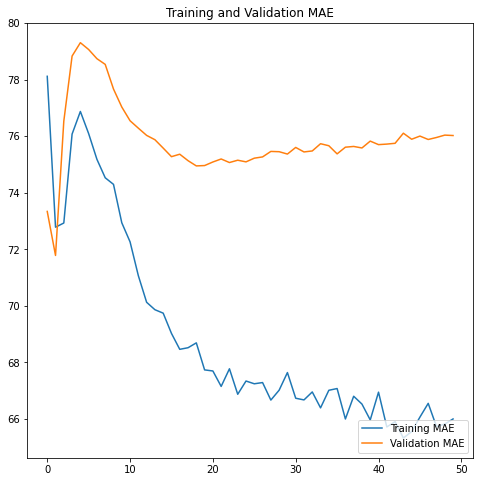

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Fine Tune

In [30]:
base_model.trainable=False
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  467


In [32]:
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.9)
print(fine_tune_at)

420


In [34]:
# 동결 해제
fine_tune_at = int(len(base_model.layers) * 0.9)
for i, layer in enumerate(base_model.layers) :
    if i < fine_tune_at :
        layer.trainable = False
    else :
           if 'bn' in layer.name :
                layer.trainable = False

In [35]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, None, None, 1792)  17673816  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1792)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                114752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

### 1. best weights 안 불러오고 그냥 이어서 학습

In [36]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [37]:
checkpoint_filepath = './Model_Save/eff_b4/effb4_fine1.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)
model.save('./Model_Save/effb4_1.h5')

Epoch 1/30
159/159 [==============================] - 20s 83ms/step - loss: 8411.0687 - mae: 66.9029 - val_loss: 10460.9922 - val_mae: 75.9322

Epoch 00001: val_mae improved from inf to 75.93224, saving model to ./Model_Save/eff_b4/effb4_fine1.ckpt
Epoch 2/30
159/159 [==============================] - 11s 71ms/step - loss: 8013.8077 - mae: 65.7638 - val_loss: 10464.7256 - val_mae: 76.2602

Epoch 00002: val_mae did not improve from 75.93224
Epoch 3/30
159/159 [==============================] - 11s 71ms/step - loss: 8222.3697 - mae: 65.7207 - val_loss: 10464.4707 - val_mae: 75.9854

Epoch 00003: val_mae did not improve from 75.93224
Epoch 4/30
159/159 [==============================] - 11s 71ms/step - loss: 7895.8791 - mae: 64.1953 - val_loss: 10439.9932 - val_mae: 76.0123

Epoch 00004: val_mae did not improve from 75.93224
Epoch 5/30
159/159 [==============================] - 11s 71ms/step - loss: 7971.6966 - mae: 64.9808 - val_loss: 10326.1699 - val_mae: 76.3661

Epoch 00005: val_mae d

Text(0.5, 1.0, 'Training and Validation MAE')

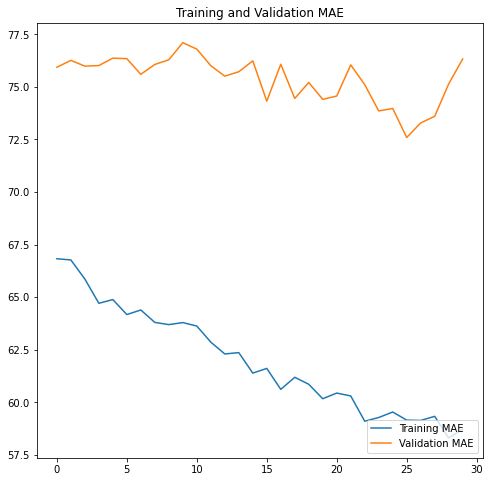

In [39]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### Prediction

In [41]:
PRED_BATCH_SIZE = 10
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

  0%|          | 0/460 [00:00<?, ?it/s]

In [42]:
STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)

In [45]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./data/effecientnet_cnn.csv', index=False)

### 2. best weight 불러오고학습

In [44]:
model.load_weights('./Model_Save/eff_b4/effb4.ckpt')
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [46]:
checkpoint_filepath = './Model_Save/eff_b4/effb4_fine1.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 20s 88ms/step - loss: 13369.1876 - mae: 74.5037 - val_loss: 10514.3867 - val_mae: 74.8775

Epoch 00001: val_mae improved from inf to 74.87750, saving model to ./Model_Save/eff_b4/effb4_fine1.ckpt
Epoch 2/30
159/159 [==============================] - 11s 72ms/step - loss: 11458.2584 - mae: 75.5083 - val_loss: 10097.0908 - val_mae: 75.0399

Epoch 00002: val_mae did not improve from 74.87750
Epoch 3/30
159/159 [==============================] - 11s 72ms/step - loss: 9939.8047 - mae: 72.8993 - val_loss: 10074.0137 - val_mae: 75.5479

Epoch 00003: val_mae did not improve from 74.87750
Epoch 4/30
159/159 [==============================] - 11s 72ms/step - loss: 10227.1492 - mae: 73.5351 - val_loss: 10067.9443 - val_mae: 75.9680

Epoch 00004: val_mae did not improve from 74.87750
Epoch 5/30
159/159 [==============================] - 11s 72ms/step - loss: 9210.1266 - mae: 71.2829 - val_loss: 10012.6484 - val_mae: 74.7607

Epoch 00005: val_ma

In [47]:
model.load_weights(checkpoint_filepath)
model.save('./Model_Save/effb4_2.h5')

Text(0.5, 1.0, 'Training and Validation MAE')

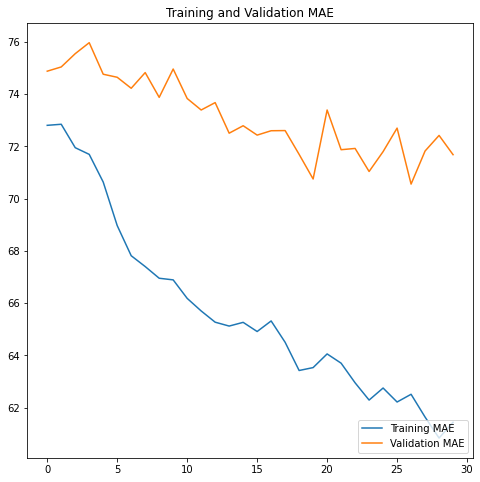

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [ ]:
# prediction = model.predict(test_dataset,
#                             batch_size = PRED_BATCH_SIZE,
#                             steps=STEPS)

# submission = pd.read_csv('./data/sample_submission.csv')
# submission['leaf_weight'] = prediction.squeeze()
# submission.to_csv('./data/effecientnet_cnn.csv', index=False)

## mae 점수가 별로 안좋아서 생략

# Dropout 제거

In [49]:
LEARNING_RATE = 2e-4 
EPOCH = 30

In [50]:
base_model2 = efn.EfficientNetB4(
    weights='imagenet',
    include_top = False
)
base_model2.trainable = False

In [51]:
base_model2.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [54]:
model2 = Sequential()
# model.add(data_augmentation)
model2.add(preprocess)
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [55]:
history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[es, checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 18s 74ms/step - loss: 80.8621 - mae: 80.8621 - val_loss: 71.1600 - val_mae: 71.1600

Epoch 00001: val_mae did not improve from 70.55599
Epoch 2/30
159/159 [==============================] - 10s 61ms/step - loss: 73.9847 - mae: 73.9847 - val_loss: 69.7006 - val_mae: 69.7006

Epoch 00002: val_mae improved from 70.55599 to 69.70061, saving model to ./Model_Save/eff_b4/effb4_fine1.ckpt
Epoch 3/30
159/159 [==============================] - 10s 61ms/step - loss: 71.8307 - mae: 71.8307 - val_loss: 68.7924 - val_mae: 68.7924

Epoch 00003: val_mae improved from 69.70061 to 68.79240, saving model to ./Model_Save/eff_b4/effb4_fine1.ckpt
Epoch 4/30
159/159 [==============================] - 10s 61ms/step - loss: 70.5717 - mae: 70.5717 - val_loss: 68.0827 - val_mae: 68.0827

Epoch 00004: val_mae improved from 68.79240 to 68.08271, saving model to ./Model_Save/eff_b4/effb4_fine1.ckpt
Epoch 5/30
159/159 [==============================] - 10s 61ms/

In [63]:
mae = history2.history['mae']
val_mae = history2.history['val_mae']

In [57]:
base_model2.trainable = True
fine_tune_at = int(len(base_model2.layers) * 0.9)
for i, layer in enumerate(base_model2.layers) :
    if i < fine_tune_at :
        layer.trainable = False
    else :
           if 'bn' in layer.name :
                layer.trainable = False

In [58]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, None, None, 1792)  17673816  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1792)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                114752    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 17,792,793
Trainable params: 6,524,985
Non-trainable params: 11,267,808
__________________________________

In [62]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])


checkpoint_filepath = './Model_Save/eff_b4/effb4_fine2.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history2_fine = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[es, checkpointer],
                    verbose=1)
model2.save('./Model_Save/effb4_2.h5')

Epoch 1/30
159/159 [==============================] - 20s 84ms/step - loss: 60.0911 - mae: 60.0911 - val_loss: 66.1822 - val_mae: 66.1822

Epoch 00001: val_mae improved from inf to 66.18220, saving model to ./Model_Save/eff_b4/effb4_fine2.ckpt
Epoch 2/30
159/159 [==============================] - 11s 72ms/step - loss: 57.1602 - mae: 57.1602 - val_loss: 65.5967 - val_mae: 65.5967

Epoch 00002: val_mae improved from 66.18220 to 65.59673, saving model to ./Model_Save/eff_b4/effb4_fine2.ckpt
Epoch 3/30
159/159 [==============================] - 11s 72ms/step - loss: 57.1411 - mae: 57.1411 - val_loss: 65.2846 - val_mae: 65.2846

Epoch 00003: val_mae improved from 65.59673 to 65.28465, saving model to ./Model_Save/eff_b4/effb4_fine2.ckpt
Epoch 4/30
159/159 [==============================] - 11s 72ms/step - loss: 56.1173 - mae: 56.1173 - val_loss: 65.5727 - val_mae: 65.5727

Epoch 00004: val_mae did not improve from 65.28465
Epoch 5/30
159/159 [==============================] - 11s 72ms/step 

Text(0.5, 1.0, 'Training and Validation MAE')

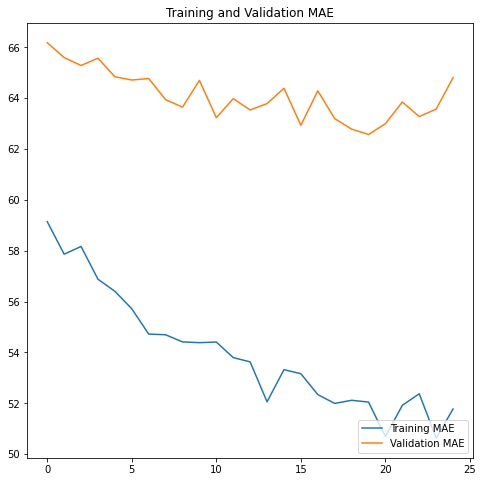

In [64]:
plt.figure(figsize=(8, 8))
plt.plot(history2_fine.history['mae'], label='Training MAE')
plt.plot(history2_fine.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')